# Forecasting Rainfall in Australia

Group 62 

Nicholas Brennan: 46030158 | Alexandra Ellison: 45888949

*Note: Due to time constraints we were unable to collect all the available Australian weather data and have limited our model's to weather data from NSW & ACT only.*

## Intoduction 

Forecasting rainfall can be a challenging and uncertain task, however is essential for the management and prevention of catastrophic outcomes. In this portfolio we use 14 months of historic weather data from NSW. Using this data we attempt to build 4 separate classification models and evaluate their effectiveness in predicting weather or not it will rain the next day. 

## Goals

Our goal is to evaluate 4 separate machine learning models and based on the days weather data, how accurate these model's can predict if an area will experience rain fall the next day. Our 4 models we are using for evaluation are: 

1. Logistic Regression 
2. K-Nearest Neighbors 
3. Artificial Neural Network
4. Decision Tree

In the following portfolio, we will create and tune each model to obtain the highest performing model and evalute each one to determine the optimal model for our predictions. 

## Our Data 

We will be using data obtained from the [Bureau of Meteorology](http://www.bom.gov.au). The website has 14 months of freely available historic weather data for all weather stations accross Australia. As noted above, we will be focusing on only the past 14 months of data from NSW and ACT. 

The data comes in CSV format but will need to be extensively cleaned and modified to remove useless lines and headings. Then the each csv file will be consolidated into a single data frame. 

### Importing Libraries 

In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
from sklearn import tree
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

### Miscellaneous Functions

Below are numerous functions used throughout this portfolio.

In [2]:
def getLocation(input):
    location = input.split('from ')
    location = location[1].split(' AWS')
    location = location[0].split(' (')
    location = location[0].split(' {')
    return location[0]

In [3]:
def splitString(data):
    idx = 0 
    name = ""
    for i in range(len(data)):
        if 'Observations were drawn from' in data[i][0]:
            name = getLocation(data[i][0])
            idx = i
        if 'are from' in data[i][0]:
            name = getLocation(data[i][0])
            idx = i
    return name, idx

In [4]:
def readCSV(path):
    data = []
    with open(path, 'r', newline='', encoding='unicode escape') as csv_file:
        file = csv.reader(csv_file)
        for row in file:
            if row:
                data.append(row)
    name, idx = splitString(data)
    temp_df = pd.DataFrame(data[idx+2:], columns=data[idx+1])
    temp_df.insert(0, 'Location', name)
    return temp_df

In [5]:
def confMatrix(data, length):
    trueNeg = "True Neg\n %0.2d\n %0.2f%%" % (data[0][0], data[0][0] / length * 100)
    falsePos = "False Pos\n %0.2d\n %0.2f%%" % (data[0][1], data[0][1] / length * 100)
    falseNeg = "False Neg\n %0.2d\n %0.2f%%" % (data[1][0], data[1][0] / length * 100)
    truePos = "True Pos\n %0.2d\n %0.2f%%" % (data[1][1], data[1][1] / length * 100)
    labels = np.array([[trueNeg, falsePos], [falseNeg, truePos]])
    return sns.heatmap(data=data, cmap="coolwarm", annot=labels, fmt='')

# Data Preprocessing

This is used to collect the addresses of all cvs files to be used and consolidate them into a single data frame.

In [6]:
dir = r'files'
csv_files = [f for f in Path(dir).glob('*.csv')]
len(csv_files)

2537

## Data Frame Creation

### Create Initial Data Frame 

First an initial data frame is made with the relevant columns from the first csv file.

In [7]:
weather = readCSV(csv_files[0])

In [8]:
weather.head()

,Location,,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,Albion Park,,2020-09-1,4.8,16.7,0,,,NE,28,...,4,NNW,6,1025.1,16.1,58,,ENE,19,1021.4
1,Albion Park,,2020-09-2,5.5,23.7,0,,,NW,52,...,,N,19,1020.2,19.9,61,,ENE,20,1015.0
2,Albion Park,,2020-09-3,9.1,31.1,0,,,W,59,...,7,NNE,13,1014.8,28.7,25,2,W,31,1011.9
3,Albion Park,,2020-09-4,12.1,21.8,0,,,NE,22,...,8,WSW,13,1017.8,19.2,67,8,E,7,1014.2
4,Albion Park,,2020-09-5,7.7,22.7,0.4,,,WSW,41,...,,WSW,28,1016.5,19.6,43,6,E,17,1016.5


### Append Remaning CSV Files 

This appends all remaining cvs files into one large data frame.

In [9]:
for i in range(len(csv_files)): 
    weather = weather.append(readCSV(csv_files[i]), ignore_index=True)

In [10]:
weather.shape

(76247, 23)

### Drop Duplicates 

To ensure the data frame contains only unique entries, the duplicates are dropped.

In [11]:
weather.drop_duplicates(inplace=True)
weather.shape

(76217, 23)

## Clean Data

### Correct Empty Strings

Replacing all empty strings with NaN.

In [12]:
weather = weather.replace(r'^\s*$', np.NaN, regex=True)
weather.head()

,Location,,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,Albion Park,NaN,2020-09-1,4.8,16.7,0,NaN,NaN,NE,28,...,4,NNW,6,1025.1,16.1,58,NaN,ENE,19,1021.4
1,Albion Park,NaN,2020-09-2,5.5,23.7,0,NaN,NaN,NW,52,...,NaN,N,19,1020.2,19.9,61,NaN,ENE,20,1015.0
2,Albion Park,NaN,2020-09-3,9.1,31.1,0,NaN,NaN,W,59,...,7,NNE,13,1014.8,28.7,25,2,W,31,1011.9
3,Albion Park,NaN,2020-09-4,12.1,21.8,0,NaN,NaN,NE,22,...,8,WSW,13,1017.8,19.2,67,8,E,7,1014.2
4,Albion Park,NaN,2020-09-5,7.7,22.7,0.4,NaN,NaN,WSW,41,...,NaN,WSW,28,1016.5,19.6,43,6,E,17,1016.5


In [13]:
weather.drop('', axis=1, inplace=True)

### Remove "Calm" Found in Some Cells 

Inital exploration showed that some entries contained 'Calm' as their input. Therefore, we have decided to just consider them as NaN.

In [14]:
weather = weather.replace('Calm', np.NaN)

### Convert Strings to Floats 

The below code is to convert all columns that should be numeric into floats.

In [15]:
columns = ['Minimum temperature (°C)','Maximum temperature (°C)','Rainfall (mm)','Evaporation (mm)',
           'Sunshine (hours)','Speed of maximum wind gust (km/h)','9am wind speed (km/h)','9am MSL pressure (hPa)',
           '3pm Temperature (°C)','3pm relative humidity (%)','3pm cloud amount (oktas)','3pm wind speed (km/h)',
           '3pm MSL pressure (hPa)', '9am Temperature (°C)', '9am relative humidity (%)', '9am cloud amount (oktas)']
weather[columns] = weather[columns].replace(',','.', regex=True).astype(float)

In [16]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76217 entries, 0 to 76246
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Location                           76217 non-null  object 
 1   Date                               76217 non-null  object 
 2   Minimum temperature (°C)           70240 non-null  float64
 3   Maximum temperature (°C)           70466 non-null  float64
 4   Rainfall (mm)                      72019 non-null  float64
 5   Evaporation (mm)                   7729 non-null   float64
 6   Sunshine (hours)                   1596 non-null   float64
 7   Direction of maximum wind gust     48636 non-null  object 
 8   Speed of maximum wind gust (km/h)  48645 non-null  float64
 9   Time of maximum wind gust          48743 non-null  object 
 10  9am Temperature (°C)               70852 non-null  float64
 11  9am relative humidity (%)          69535 non-null  flo

### Handling Missing Data

The next step is to manage missing data.

In [17]:
weather.isna().sum()

Location                                 0
Date                                     0
Minimum temperature (°C)              5977
Maximum temperature (°C)              5751
Rainfall (mm)                         4198
Evaporation (mm)                     68488
Sunshine (hours)                     74621
Direction of maximum wind gust       27581
Speed of maximum wind gust (km/h)    27572
Time of maximum wind gust            27474
9am Temperature (°C)                  5365
9am relative humidity (%)             6682
9am cloud amount (oktas)             43375
9am wind direction                   14639
9am wind speed (km/h)                14383
9am MSL pressure (hPa)               37673
3pm Temperature (°C)                 23929
3pm relative humidity (%)            25078
3pm cloud amount (oktas)             62717
3pm wind direction                   24863
3pm wind speed (km/h)                24863
3pm MSL pressure (hPa)               37673
dtype: int64

As seen above, there is a significant amount of missing data.

#### Remove Rows with Missing Rainfall Values

As explained above, we are using the rainfall measurements to create a predictive variable. As there is so few missing rainfall inputs and we do not want our model's to be effected by estimating the missing values, we have opted to remove the rows with missing rainfall inputs.

In [18]:
weather.shape

(76217, 22)

In [19]:
weather.dropna(subset=['Rainfall (mm)'], inplace=True)
weather.shape

(72019, 22)

#### Categorical Data

This step is using sklearn's simple imputer with the 'most_frequent' strategy on our missing categorical data.

In [20]:
print('Direction of maximum wind gust: ', weather['Direction of maximum wind gust '].isna().sum())
print('9am wind direction:             ', weather['9am wind direction'].isna().sum())
print('3pm wind direction:             ', weather['3pm wind direction'].isna().sum())

Direction of maximum wind gust:  26337
9am wind direction:              13563
3pm wind direction:              23821


In [21]:
columns = ['Direction of maximum wind gust ', '9am wind direction', '3pm wind direction']
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_df = pd.DataFrame(imputer.fit_transform(weather[columns]), index=weather.index, columns=columns)
weather.drop(columns, axis=1, inplace=True)
weather = weather.join(imp_df)

In [22]:
print('Direction of maximum wind gust: ', weather['Direction of maximum wind gust '].isna().sum())
print('9am wind direction:             ', weather['9am wind direction'].isna().sum())
print('3pm wind direction:             ', weather['3pm wind direction'].isna().sum())

Direction of maximum wind gust:  0
9am wind direction:              0
3pm wind direction:              0


#### Numerical Data

For numerical data, we are again using sklearn's simple imputer with the 'mean' strategy.

In [23]:
num_columns = weather.select_dtypes(include=['float64']).columns.tolist()
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_df = pd.DataFrame(imputer.fit_transform(weather[num_columns]), index=weather.index, columns=num_columns)
weather.drop(num_columns, axis=1, inplace=True)
weather = weather.join(imp_df)

In [24]:
weather.isna().sum()

Location                                 0
Date                                     0
Time of maximum wind gust            26240
Direction of maximum wind gust           0
9am wind direction                       0
3pm wind direction                       0
Minimum temperature (°C)                 0
Maximum temperature (°C)                 0
Rainfall (mm)                            0
Evaporation (mm)                         0
Sunshine (hours)                         0
Speed of maximum wind gust (km/h)        0
9am Temperature (°C)                     0
9am relative humidity (%)                0
9am cloud amount (oktas)                 0
9am wind speed (km/h)                    0
9am MSL pressure (hPa)                   0
3pm Temperature (°C)                     0
3pm relative humidity (%)                0
3pm cloud amount (oktas)                 0
3pm wind speed (km/h)                    0
3pm MSL pressure (hPa)                   0
dtype: int64

### Categorical Encoding

Now that the missing data is handled, we will use panda's get_dummies function to encode some of our categorical features. specifically we are only encoding 'Direction of maximum wind gust ', '9am wind direction' and '3pm wind direction'. All three features are wind directions eg. N, S, W, E, NW etc.

In [25]:
categorical_feat = weather.select_dtypes(include=['object']).columns.tolist()
print('Number of categorical features: ', len(categorical_feat))
print('Features: ' ,categorical_feat)

Number of categorical features:  6
Features:  ['Location', 'Date', 'Time of maximum wind gust', 'Direction of maximum wind gust ', '9am wind direction', '3pm wind direction']


In [26]:
columns = ['Direction of maximum wind gust ', '9am wind direction', '3pm wind direction']
weather = pd.get_dummies(weather, columns=columns)
weather.columns

Index(['Location', 'Date', 'Time of maximum wind gust',
       'Minimum temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)',
       'Evaporation (mm)', 'Sunshine (hours)',
       'Speed of maximum wind gust (km/h)', '9am Temperature (°C)',
       '9am relative humidity (%)', '9am cloud amount (oktas)',
       '9am wind speed (km/h)', '9am MSL pressure (hPa)',
       '3pm Temperature (°C)', '3pm relative humidity (%)',
       '3pm cloud amount (oktas)', '3pm wind speed (km/h)',
       '3pm MSL pressure (hPa)', 'Direction of maximum wind gust _E',
       'Direction of maximum wind gust _ENE',
       'Direction of maximum wind gust _ESE',
       'Direction of maximum wind gust _N',
       'Direction of maximum wind gust _NE',
       'Direction of maximum wind gust _NNE',
       'Direction of maximum wind gust _NNW',
       'Direction of maximum wind gust _NW',
       'Direction of maximum wind gust _S',
       'Direction of maximum wind gust _SE',
       'Direction of maximum w

### Convert Date/Time Strings

Here we are converting the strings found in the columns 'Time of maximum wind gust' and 'Date' into panda's datetime objects.

In [27]:
weather['Date'] = pd.to_datetime(weather['Date'])
weather['Time of maximum wind gust'] = pd.to_datetime(weather['Time of maximum wind gust'])

In [28]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72019 entries, 0 to 76246
Data columns (total 67 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Location                             72019 non-null  object        
 1   Date                                 72019 non-null  datetime64[ns]
 2   Time of maximum wind gust            45779 non-null  datetime64[ns]
 3   Minimum temperature (°C)             72019 non-null  float64       
 4   Maximum temperature (°C)             72019 non-null  float64       
 5   Rainfall (mm)                        72019 non-null  float64       
 6   Evaporation (mm)                     72019 non-null  float64       
 7   Sunshine (hours)                     72019 non-null  float64       
 8   Speed of maximum wind gust (km/h)    72019 non-null  float64       
 9   9am Temperature (°C)                 72019 non-null  float64       
 10  9am relati

## Add Rain Today & Rain Tomorrow Columns

Our intention for the predictive variable is to create a new column 'Rain_Today' that is set to 1 (true) is the rainfall for that data is > 1.0mm and 0 (false) if it is <= 1.00mm. We then create a new column 'Rain_Tomorrow' that is a copy of 'Rain_Today' but offset by -1 day. As this process will create some NaN values in the 'Rain_Tomorrow' column, we have opted to again drop these rows.

In [29]:
weather['Rain_Today'] = np.where(weather['Rainfall (mm)'] > 1.0, 1, 0)

In [30]:
weather = weather.assign(Rain_Tomorrow=weather.groupby('Location').Rain_Today.shift(-1))

#### Remove NaN Rows

In [31]:
weather.shape

(72019, 69)

In [32]:
weather.dropna(subset=['Rain_Tomorrow'], inplace=True)
weather.shape

(71858, 69)

In [33]:
weather.head()

,Location,Date,Time of maximum wind gust,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am Temperature (°C),...,3pm wind direction_S,3pm wind direction_SE,3pm wind direction_SSE,3pm wind direction_SSW,3pm wind direction_SW,3pm wind direction_W,3pm wind direction_WNW,3pm wind direction_WSW,Rain_Today,Rain_Tomorrow
0,Albion Park,2020-09-01,2021-11-07 13:01:00,4.8,16.7,0.0,4.477686,7.412934,28.0,14.0,...,0,0,0,0,0,0,0,0,0,0.0
1,Albion Park,2020-09-02,2021-11-07 23:58:00,5.5,23.7,0.0,4.477686,7.412934,52.0,16.3,...,0,0,0,0,0,0,0,0,0,0.0
2,Albion Park,2020-09-03,2021-11-07 12:18:00,9.1,31.1,0.0,4.477686,7.412934,59.0,23.2,...,0,0,0,0,0,1,0,0,0,0.0
3,Albion Park,2020-09-04,2021-11-07 12:58:00,12.1,21.8,0.0,4.477686,7.412934,22.0,18.8,...,0,0,0,0,0,0,0,0,0,0.0
4,Albion Park,2020-09-05,2021-11-07 09:04:00,7.7,22.7,0.4,4.477686,7.412934,41.0,17.4,...,0,0,0,0,0,0,0,0,0,0.0


## Data Scaling 

The final set is to scale the data to help manage any features that may skew our predictive model's. For this process we are using sklearn's MinMaxScaler to achieve this.

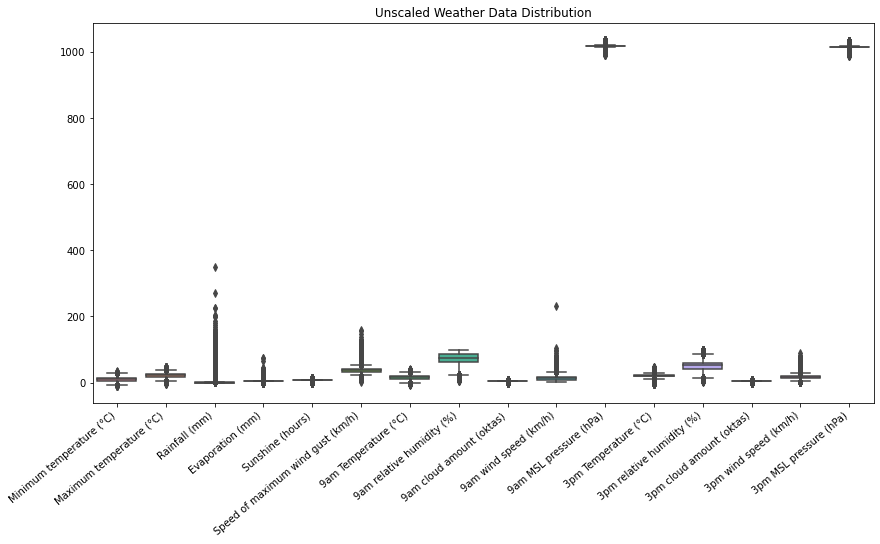

In [34]:
plt.figure(figsize=(14, 7))
ax = sns.boxplot(data=weather[num_columns])
ax.set_title('Unscaled Weather Data Distribution')
temp = ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

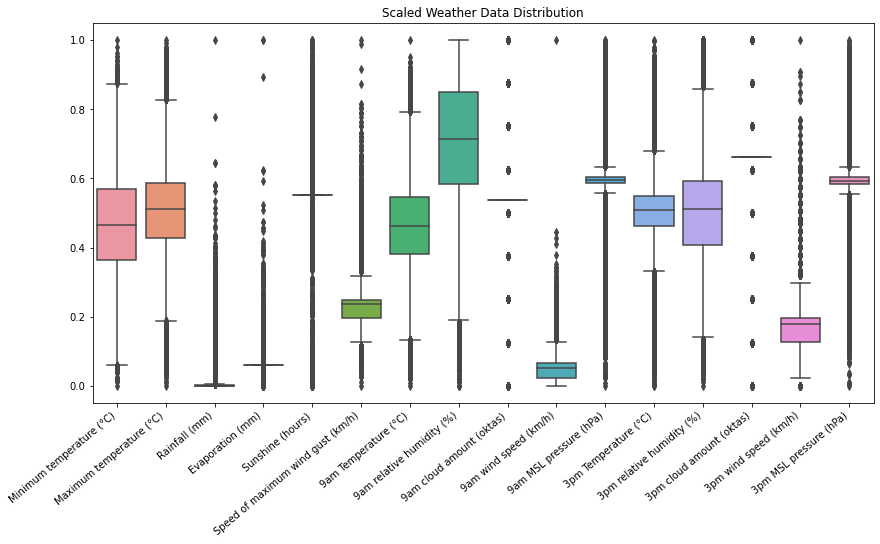

In [35]:
plt.figure(figsize=(14, 7))
scaler = MinMaxScaler()
weather[num_columns] = scaler.fit_transform(weather[num_columns])
ax = sns.boxplot(data=weather[num_columns])
ax.set_title('Scaled Weather Data Distribution')
temp = ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

## Exploratory Analysis

We will begin to investigate the data and discover any immediately significant correlation between the features or patterns in the data.

In [36]:
# calculating how many rain days
rain_days = weather['Rain_Tomorrow'].value_counts()
rain_days = rain_days.rename({0:'No Rain Tomorrow', 1:'Rain Tomorrow'})
print(rain_days)

No Rain Tomorrow    55523
Rain Tomorrow       16335
Name: Rain_Tomorrow, dtype: int64


Text(0, 0.5, 'Days')

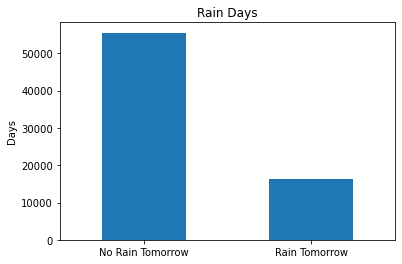

In [37]:
# check rain days
rain_days.plot(kind='bar')
plt.xticks(rotation=0)
plt.title("Rain Days")
plt.ylabel("Days")

The data is unbalanced, which suggests less rain days across the stations in NSW. 

In [38]:
# numerical features
numerical_feat = ['Minimum temperature (°C)','Maximum temperature (°C)','Rainfall (mm)','Evaporation (mm)',
           'Sunshine (hours)','Speed of maximum wind gust (km/h)','9am wind speed (km/h)','9am MSL pressure (hPa)',
           '3pm Temperature (°C)','3pm relative humidity (%)','3pm cloud amount (oktas)','3pm wind speed (km/h)',
           '3pm MSL pressure (hPa)', '9am Temperature (°C)', '9am relative humidity (%)', '9am cloud amount (oktas)', 'Rain_Today', 'Rain_Tomorrow']

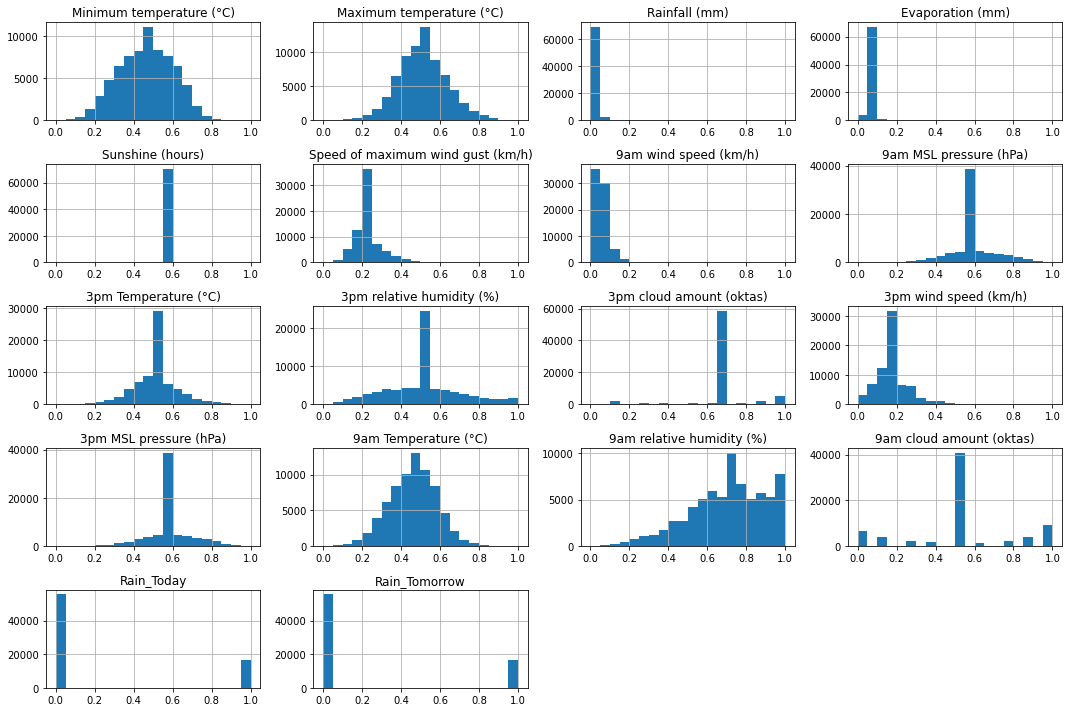

In [39]:
# plot numerical features
weather[numerical_feat].hist(bins=20, figsize=(15, 10))
plt.tight_layout()

A lot of the data appears to be close to normally distributed, however 9am wind speed appears to be right-skewed, and 9am relatively humidity left-skewed. 

## Correlations between Features and Rain Tomorrow

In [40]:
correl = (weather[numerical_feat].corr().Rain_Tomorrow).sort_values(ascending=False)
correl = correl[1:]

<AxesSubplot:>

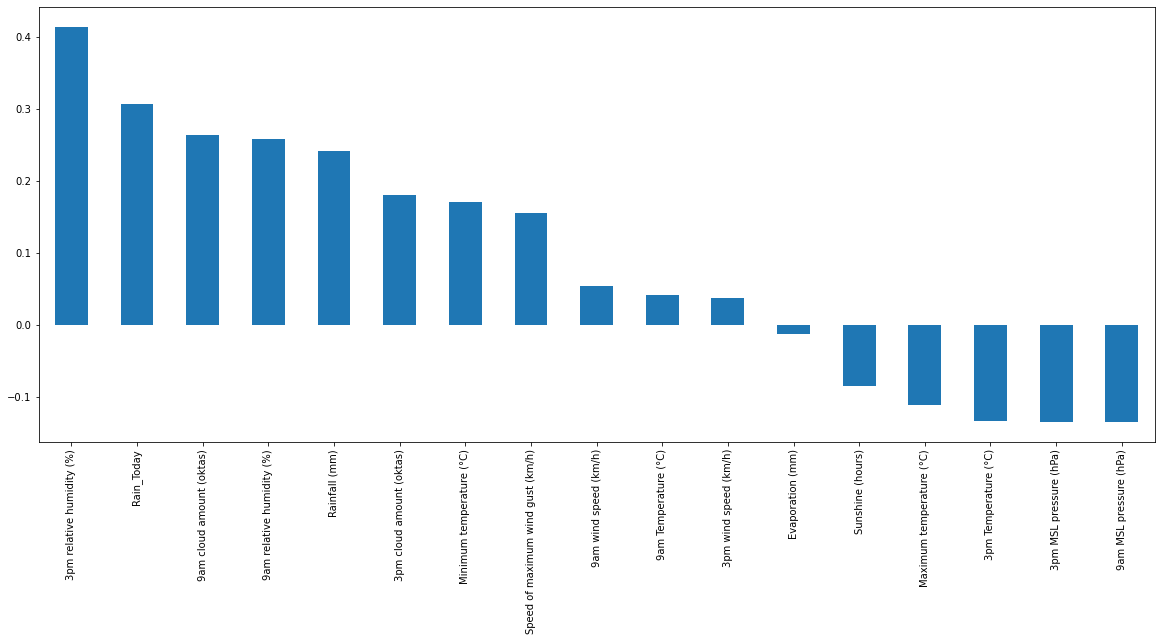

In [41]:
plt.figure(figsize=(20,8))
correl.plot.bar()

We can see the relative humifity, Rain Today and cloud amounts are all positively correlated with Rain Tomorrow, suggesting that these features are significant in predicting Rain Tomorrow. 

<AxesSubplot:>

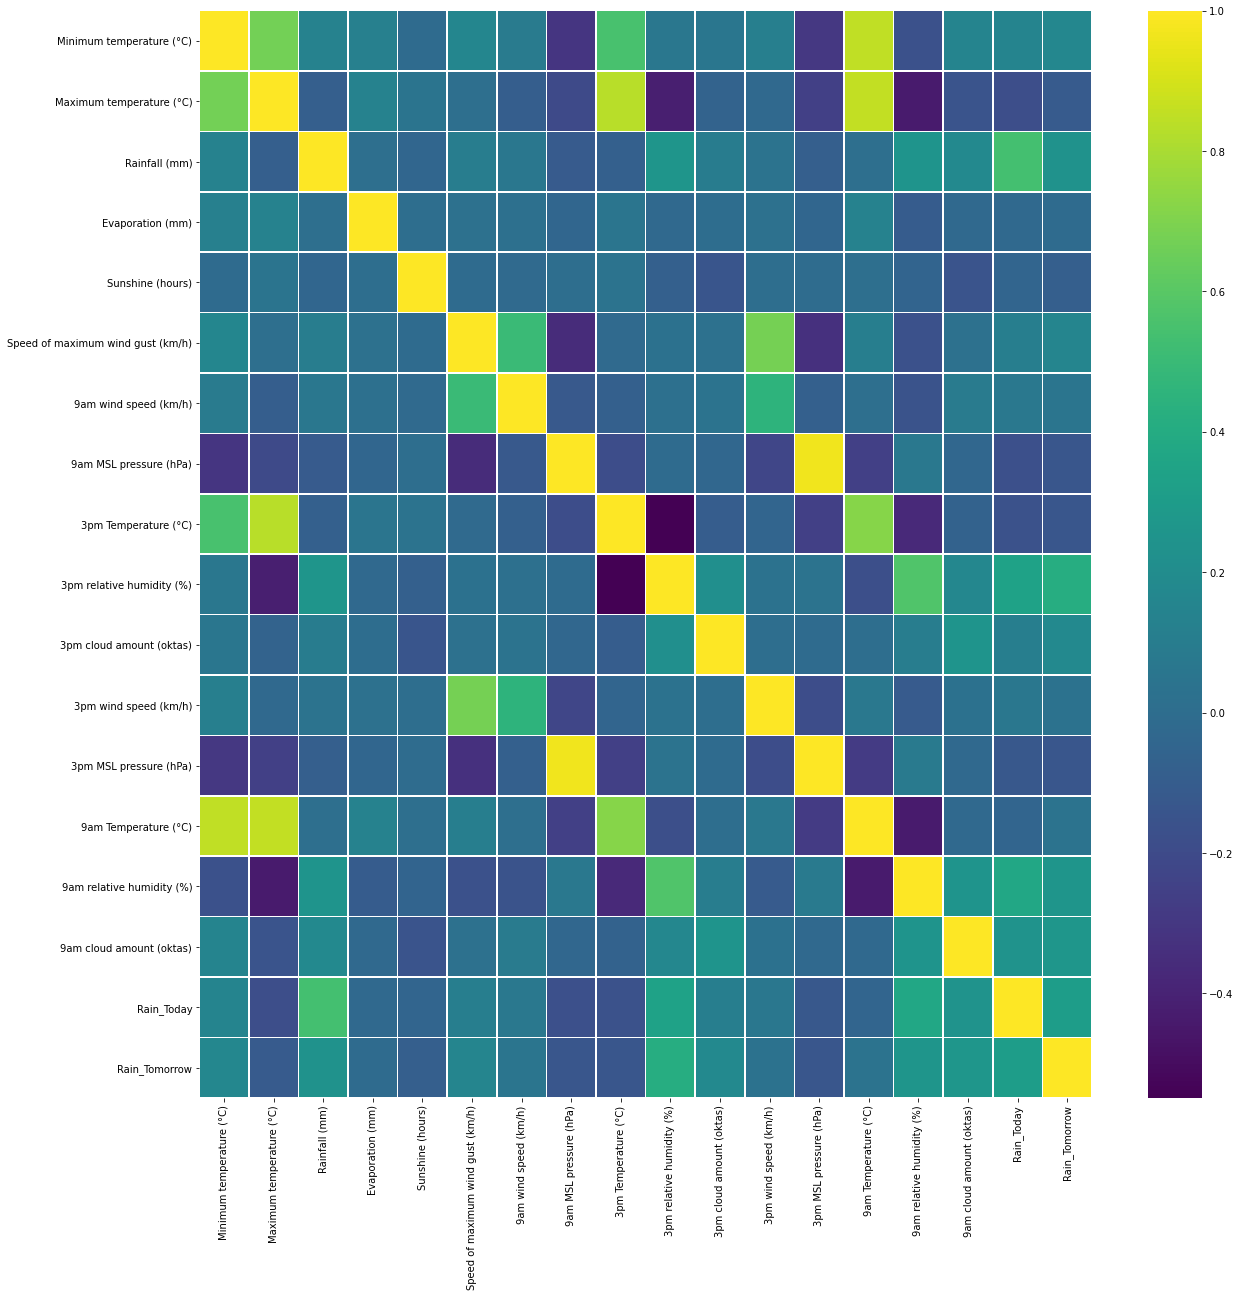

In [42]:
plt.figure(figsize=(20,20))
sns.heatmap(weather[numerical_feat].corr(), linewidths=0.5, annot=False, fmt=".2f", cmap = 'viridis')

The heatmap shows us that the air pressures and temperatures are strongly positively correlated, while humidity appears to be negatively correlated.

## Logistic Regression Model

The logistic regression model will provide predictive probabilities for the change of Rain Tomorrow.

In [43]:
drop = ['Location', 'Date', 'Rain_Today', 'Rain_Tomorrow', 'Time of maximum wind gust']
X = weather.drop(drop, axis = 'columns')
y = weather['Rain_Tomorrow']

In [44]:
# Split data into 80% training and 20% testing, random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(57486, 64)
(14372, 64)


In [45]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [46]:
lr.coef_
lr.intercept_

array([-7.13682412])

In [47]:
# Do predictions on test set
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)
print("Training set accuracy: ", accuracy_score(y_train, train_preds))
print("Testing set accuracy: ", accuracy_score(y_test, test_preds))

Training set accuracy:  0.8299759941550986
Testing set accuracy:  0.8334956860562204


The accuracy for the training and testing set suggests that this Logistic Regression performs well for modelling the data. There is no indication of overfitting as these accuracy scores are very similar. 

## Model Evaluation

For this classification model, we will look at how many cases were classified correctly under the testing set. That is, how many cases of Rain Tomorrow were correctly identified. 

In [48]:
# Evaluating the performance of the trained model
print("Train Confusion Matrix")
print(confusion_matrix(y_train, train_preds))

print("Test Confusion Matrix")
print(confusion_matrix(y_test, test_preds))

Train Confusion Matrix
[[42039  2300]
 [ 7474  5673]]
Test Confusion Matrix
[[10603   581]
 [ 1812  1376]]


<Figure size 720x576 with 0 Axes>

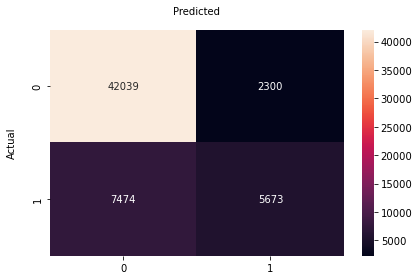

In [49]:
cm = confusion_matrix(y_train, train_preds)
plt.figure(figsize=(10, 8))
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='g')
class_names=[0, 1]
ax.xaxis.set_label_position("top")
plt.ylabel('Actual\n')
plt.xlabel('Predicted\n')
plt.tight_layout()

The confusion matrix alongside accuracy score suggests a the Logistic Regression to be reasonably strong model for predicting rainfall in NSW and the ACT. 

## K-Nearest Neighbours Model

We will use a K-Nearest Neighbours model for this classification problem. We will instantiate K = 1 to begin our investigation.

In [50]:
# KNN classifier model
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=1)

In [51]:
# Train the model using training data
clf_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [52]:
# Find the accuracy score
test_preds = clf_knn.predict(X_test)

In [53]:
print("Test set accuracy: ", accuracy_score(y_test , test_preds))

Test set accuracy:  0.771221820205956


We will tune the hyperparameter K using the training and testing data with the Cross Validation method using n = 5 splits.

In [54]:
neighbours = []
for each in range(1, 10):
    knn_loop = KNeighborsClassifier(n_neighbors=each)
    knn_loop.fit(X_train, y_train)
    neighbours.append(knn_loop.score(X_test, y_test))

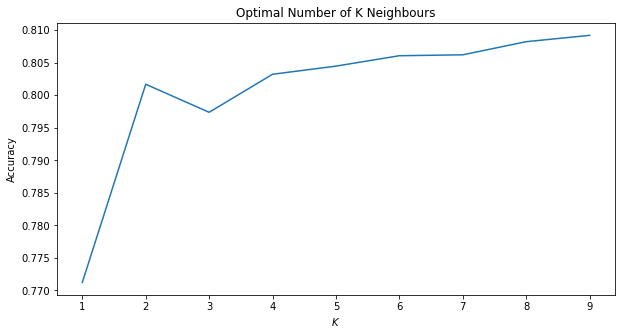

In [55]:
fig = plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), neighbours)
plt.ylabel('Accuracy')
plt.xlabel('$K$')
plt.title('Optimal Number of K Neighbours')
plt.show()

As K increases, the accuracy of the model improves to a maximum of approximating 0.8, which is achieved around 6 neighbours and onwards. This may be due to the model suffering from underfitting when K < 6. 

In [56]:
from sklearn.model_selection import GridSearchCV

parameter_grid = {"n_neighbors": range(1, 10)}
knn_clf = KNeighborsClassifier()
gs_knn = GridSearchCV(knn_clf, parameter_grid, scoring='accuracy', cv=KFold(n_splits=5, shuffle=True))
gs_knn.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 10)}, scoring='accuracy')

In [57]:
print("GS Best Parameters: ", gs_knn.best_params_)
print("With accuracy: ", gs_knn.best_score_)

GS Best Parameters:  {'n_neighbors': 9}
With accuracy:  0.8051991562777676


The GridSearch shows that the best parameters is a KNN model of 9 neighbours for this data, with accuracy 80.6% which suggests a reasonable good fit.

# Artificial Neural Network 

Here we will use an Artificial Neural Network package from sklearn. The model we are going to use is the 'MLPClassifier' that uses a Multi Layer Perceptron design. We will create an initial default model to determine if it is viable, then tune the various hyper-parameters and evaluate the final model.

## Initial Evlauation 

In [58]:
drop = ['Location', 'Date', 'Rain_Today', 'Rain_Tomorrow', 'Time of maximum wind gust']
X = weather.drop(drop, axis = 'columns')
y = weather['Rain_Tomorrow']

In [59]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

ann = MLPClassifier(random_state=42, max_iter=1000)
ann.fit(X_train, y_train)

MLPClassifier(max_iter=1000, random_state=42)

In [60]:
train_preds = ann.predict(X_train)
test_preds = ann.predict(X_test)

accuracy = accuracy_score(train_preds, y_train)
print('The training accuracy is: %.4f\n' % accuracy)

accuracy = accuracy_score(test_preds, y_test)
print('The testing accuracy is: %.4f\n' % accuracy)

The training accuracy is: 0.8695

The testing accuracy is: 0.8347



In [61]:
print('Total Number of layers : %.f\n' % ann.n_layers_)
print('MLP structure: %.f X %.f X %.f\n' % (X.shape[1], ann.get_params()['hidden_layer_sizes'][0], ann.n_outputs_))

Total Number of layers : 3

MLP structure: 64 X 100 X 1



As seen above, the default model apears to be viable with resonable accuracy and no signs of overfitting.

## Parameter Tuning

For our Neural Network tuning we will be evaluating the following hyper-parameters: 

1. Number of hidden layer nodes (hidden_layer_sizes)
2. The solvers for the learning process (solver)
3. The activiation function (activation) 
4. Alpha parameter (alpha)

Each hyper-parameter will be evaluated with a cross validation score. 

*Note: due to the considerable time taken with cross validation, we have opted to set the number of folds to 5.*

### 1. Number of Hidden Layer Nodes 

First the model will be evaluated with hidden layer sizes between the ranges of 10-100 with a step size of 10. 

In [62]:
cv_scores = []
cv_scores_std = []
hidden_unit_numbers = [[10],[20],[30],[40],[50],[60],[70],[80],[90],[100]]
for i in hidden_unit_numbers:
    ann = MLPClassifier(hidden_layer_sizes=i, random_state=42, max_iter=1000)
    scores = cross_val_score(ann, X, y, scoring='accuracy', cv=5)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

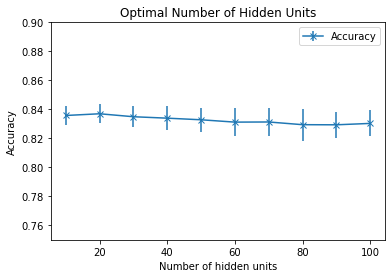

In [63]:
plt.errorbar(hidden_unit_numbers, cv_scores, yerr=cv_scores_std, marker='x', label='Accuracy')
plt.xlabel('Number of hidden units')
plt.ylim(0.75, 0.9)
plt.title('Optimal Number of Hidden Units')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

Based on the above analysis, the best hidden layer size is 20. Also it apears that the model's accuracy tends to decrease with larger sizes, indicating the possibility of overfitting.

### 2. MLP Solvers 

Here the model will be evaluated with two available sovers 'sgd' and 'adam'.

*Note: we have decided to exclude 'lbfgs' due to excessive processing time and max_iter > 15,000*

In [64]:
cv_scores = []
cv_scores_std = []
solvers = ['sgd', 'adam']
for i in solvers:
    ann = MLPClassifier(solver=i, random_state=42, max_iter=1000)
    scores = cross_val_score(ann, X, y, scoring='accuracy', cv=5)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

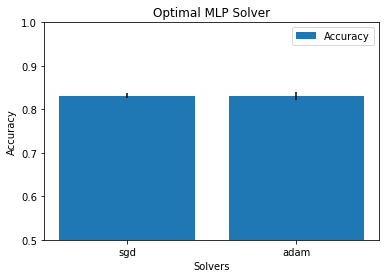

In [65]:
plt.bar(solvers, cv_scores, yerr=cv_scores_std, label='Accuracy')
plt.xlabel('Solvers')
plt.ylim([0.5, 1])
plt.title('Optimal MLP Solver')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

As per the above, the best solver we to use is 'adam'. Therefore, we will include it in the final model.

### 3. Activation Functions

In this step the model's possible activiation functions will be evaluated to determine the best one. The avaliable functions are 'identity', 'logistic', 'tanh' and 'relu'

In [66]:
cv_scores = []
cv_scores_std = []
activations = ['identity', 'logistic', 'tanh', 'relu']
for i in activations:
    ann = MLPClassifier(activation=i, random_state=42, max_iter=5000)
    scores = cross_val_score(ann, X, y, scoring='accuracy', cv=5)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

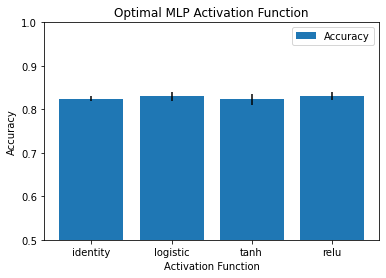

In [67]:
plt.bar(activations, cv_scores, yerr=cv_scores_std, label='Accuracy')
plt.xlabel('Activation Function')
plt.ylim([0.5, 1])
plt.ylabel('Accuracy')
plt.title('Optimal MLP Activation Function')
plt.legend(loc='best')
plt.show()

The above graph shows that all the functions are very similar in performance. However, we will be selecting 'relu' for the final model as it has slightly higher accuracy than the others. 

### 4. Alpha 

The final paramerter to be evaluated is alpha value. The range of values to be evaluated are '0.0001', '0.001', '0.01', '0.1' and '1'. 

In [68]:
cv_scores = []
cv_scores_std = []
alphas = [0.0001,0.001,0.01, 0.1,1]
for i in alphas:
    ann = MLPClassifier(alpha=i, random_state=42, max_iter=1000)
    scores = cross_val_score(ann, X, y, scoring='accuracy', cv=5)
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

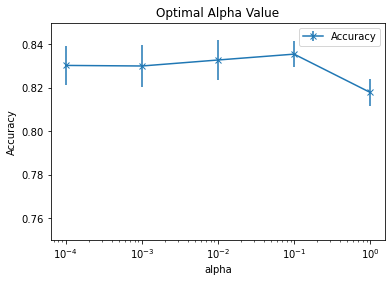

In [69]:
plt.errorbar(alphas, cv_scores, yerr=cv_scores_std, marker='x', label='Accuracy')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylim([0.75, 0.85])
plt.title('Optimal Alpha Value')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

As seen above, the perfered alpha value is 0.01. Notably the accuracy slightly increases as the alpha increases before it decreases. This signifies the potential for overfitting in this data set. 

## Final Model 

With the parameter evaluated, the final selected model includes the hyper-parameters: 

- hidden_layer_sizes = [20,20] 
- solver = adam
- activation = relu
- alpha = 0.01
- max_iter = 1000 (as per the above) 

The model will be evaluated in the following steps: 

1. Initial Testing and Training Accuracy 
2. Cross Validation & Classification Report 
3. Confusion Matrix 

In [70]:
ann = MLPClassifier(alpha=0.01, activation='relu', solver='adam', hidden_layer_sizes=[20,20], random_state=42, max_iter=1000)
ann.fit(X_train, y_train)

MLPClassifier(alpha=0.01, hidden_layer_sizes=[20, 20], max_iter=1000,
              random_state=42)

In [71]:
print('Total Number of layers : %.f\n' % ann.n_layers_)
print('MLP structure: %.f X %.f X %.f\n' % (X.shape[1], ann.get_params()['hidden_layer_sizes'][0], ann.n_outputs_))

Total Number of layers : 4

MLP structure: 64 X 20 X 1



### 1. Initial Testing and Training Accuracy

In [72]:
train_preds = ann.predict(X_train)
test_preds = ann.predict(X_test)

accuracy = accuracy_score(train_preds, y_train)
print('The training accuracy is: %.4f\n' % accuracy)

accuracy = accuracy_score(test_preds, y_test)
print('The testing accuracy is: %.4f\n' % accuracy)

The training accuracy is: 0.8481

The testing accuracy is: 0.8434



The above accuracy scores show the model shows no sign of over/under fitting

### 2. Cross Validation & Classification Report

In [73]:
cv_predict = cross_val_predict(ann, X, y, cv=5)
print(classification_report(y, cv_predict, target_names=["Outcome = 0", "Outcome = 1"]))

              precision    recall  f1-score   support

 Outcome = 0       0.86      0.94      0.90     55523
 Outcome = 1       0.71      0.47      0.57     16335

    accuracy                           0.84     71858
   macro avg       0.78      0.71      0.73     71858
weighted avg       0.82      0.84      0.82     71858



Based on the above report, the model has a resonable accuracy of 84%.

### 3. Confusion Matrix 

In [74]:
ann_confMatrix = confusion_matrix(y, cv_predict)

Text(0.5, 1.0, 'Artificial Nerual Network Confution Matrix')

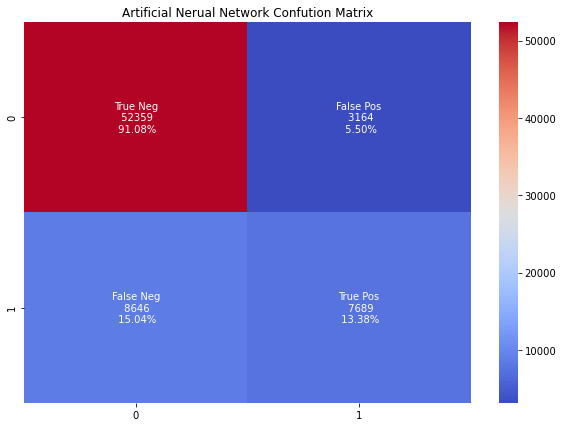

In [75]:
plt.figure(figsize=(10,7))
trainMatrix = confMatrix(ann_confMatrix, len(train_preds))
trainMatrix.set_title('Artificial Nerual Network Confution Matrix')

The above matrix shows that the ratio of true positives/negatives and false positives/negatives preditions is strong. Although the ratio false/true positives is quite similar, possibly due to the unbalanced data set. 

## Artificial Neural Network Summary 

With the above evaluations completed, the artificial neural network provides strong performance. The final model shows no over/under fitting and the cross validation provided an overall accuracy of 84%. 

Although the hyper-parameter tuning provided a small improvement to accuracy and close training and testing score. 

# Decision Tree

In this section we will be training and evaluating a Decision Tree model. We will be using sklearn's DecisionTreeClassifier to predict our prediction variable 'Rain_Tomorrow'. Again we will be evaluating the various hyper-parameters to determine the optimal model to evaluate. 

## Inital Evaluation

In [76]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf_tree = DecisionTreeClassifier(random_state=42, max_depth=4)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [77]:
train_preds = clf_tree.predict(X_train)
test_preds = clf_tree.predict(X_test)

accuracy = accuracy_score(train_preds, y_train)
print('The training accuracy is: %.4f\n' % accuracy)

accuracy = accuracy_score(test_preds, y_test)
print('The testing accuracy is: %.4f\n' % accuracy)

The training accuracy is: 0.8244

The testing accuracy is: 0.8263



The above accuracy score for the default model shows that a decision tree is viable with resonable accuracy and no signs of overfitting.

## Parameter Tuning

The decision tree will be evaluated on the following hyper-parameters:

1. Splitting Criteria (splitting_criteria)
2. Max tree depth (max_depth)

Each hyper-parameter will be evaluated with a cross validation score.

### Splitting Criteria

The decision tree will be evaluated with two splitting criterias, 'gini'and 'entropy'

In [78]:
cv_scores = []
cv_scores_std = []
splitting_criteria = ['gini', 'entropy']
for i in splitting_criteria:
    clf_tree = DecisionTreeClassifier(criterion=i, random_state=42)
    scores = cross_val_score(clf_tree, X, y, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

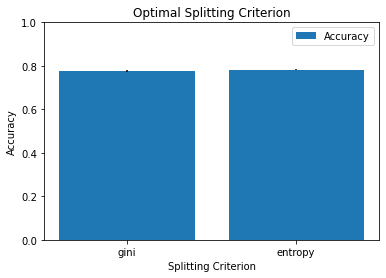

In [79]:
plt.bar(splitting_criteria, cv_scores, yerr=cv_scores_std, label='Accuracy')
plt.xlabel('Splitting Criterion')
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.title('Optimal Splitting Criterion')
plt.legend(loc='best')
plt.show()

The evaluation above shows that both criterias provide essentially the same accuracy. Therefore, we will select 'entropy' for the final model. 

### Tree Depth

The decision tree's max depth will be tested with a range of 1-30 node depth. 

In [80]:
cv_scores_std = []
cv_scores = []
depth = range(1, 31)
for i in depth:
    clf_tree = DecisionTreeClassifier(max_depth=i, criterion='entropy', random_state=42)
    scores = cross_val_score(clf_tree, X, y, scoring='accuracy', cv=KFold(n_splits=10, shuffle=True, random_state=42))
    cv_scores.append(scores.mean())
    cv_scores_std.append(scores.std())

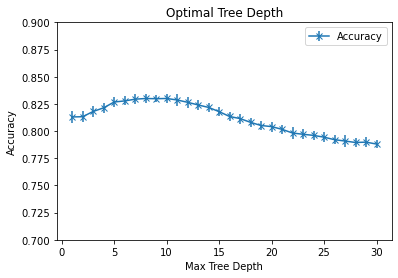

In [89]:
plt.errorbar(depth, cv_scores, yerr=cv_scores_std, marker='x', label='Accuracy')
plt.xlabel('Max Tree Depth')
plt.ylim(0.7, 0.9)
plt.title('Optimal Tree Depth')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [82]:
print('The tree depth of: %d' % (6-1))
print('with an accurcy of: %.4f\n' % cv_scores[6])

The tree depth of: 5
with an accurcy of: 0.8293



The above cross validation accuracies show that the optimal tree depth is 5 with an accuracy of nearly 83%

## Final Model 

With the parameters evaluated, the final selected model includes the hyper-parameters:

- splitting_criteria = entropy
- max_depth = 5

The model will be evaluated in the following steps:

1. Initial Testing and Training Accuracy
2. Cross Validation & Classification Report
3. Confusion Matrix

In [83]:
clf_tree = DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=42)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

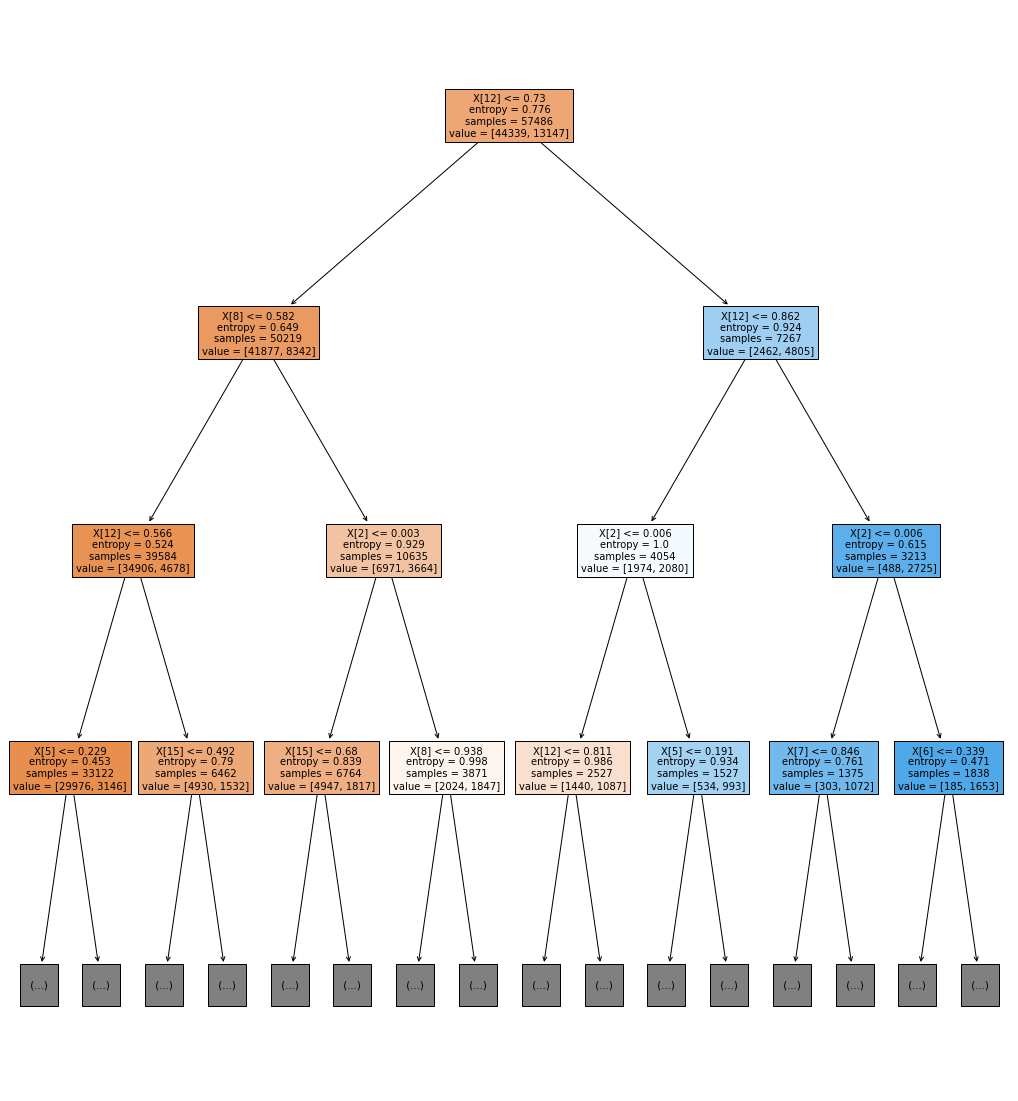

In [84]:
fig, ax = plt.subplots(figsize=(18, 20))
tree.plot_tree(clf_tree, max_depth=3, filled=True, fontsize=10)
plt.show()

### 1. Initial Testing and Training Accuracy

In [85]:
train_preds = clf_tree.predict(X_train)
test_preds = clf_tree.predict(X_test)

accuracy = accuracy_score(train_preds, y_train)
print('The training accuracy is: %.4f\n' % accuracy)

accuracy = accuracy_score(test_preds, y_test)
print('The testing accuracy is: %.4f\n' % accuracy)

The training accuracy is: 0.8287

The testing accuracy is: 0.8281



The above accuracy scores show the model shows no sign of over/under fitting

### 2. Cross Validation & Classification Report

In [86]:
cv_predict = cross_val_predict(clf_tree, X, y, cv=10)
print(classification_report(y, cv_predict, target_names=["Outcome = 0", "Outcome = 1"]))

              precision    recall  f1-score   support

 Outcome = 0       0.84      0.95      0.89     55523
 Outcome = 1       0.70      0.40      0.51     16335

    accuracy                           0.82     71858
   macro avg       0.77      0.67      0.70     71858
weighted avg       0.81      0.82      0.81     71858



The above report shows that our chosen model provides reasonable accurcy of 83%

### 3. Confusion Matrix

In [87]:
tree_confMatrix = confusion_matrix(y, cv_predict)

Text(0.5, 1.0, 'Decision Tree Confution Matrix')

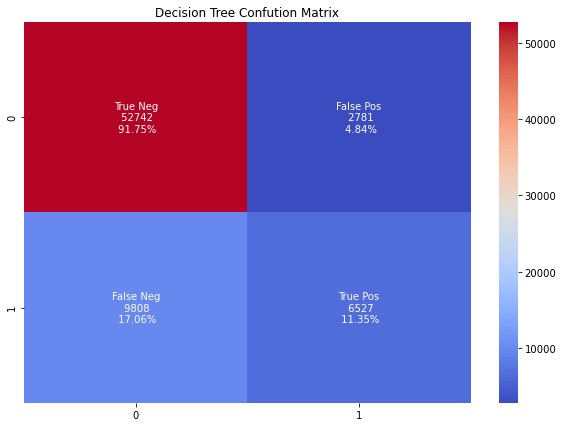

In [88]:
plt.figure(figsize=(10,7))
trainMatrix = confMatrix(tree_confMatrix, len(train_preds))
trainMatrix.set_title('Decision Tree Confution Matrix')

The above matrix shows the true positives and false negatives are reasonable acceptable. However, a significant false positives are made compared to true positives. This could be due to the unbalanced data set. 

## Decision Tree Summary 

Based on the above evaluations, the decision tree model appears to be a viable canditate for the weather prediciton model. There is no sign of of over/under fitting. The cross validation shows an overall accuracy of 82%. The true negative and false negative predictions show strong performance. 

Although the hyper-parameter tuning provided little impovement to the final model, the final decision tree model is uncomplicated and efficient. The model has a tree-depth of only 5 and the reasoning behind the model's decisions is clear and shown in the tree graph above.